In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob

sns.set_context("talk", font_scale=1.0)

In [76]:
# Directory containing the JSON files
directory_path = 'validate/'

# List to store the processed data
all_experiments = []

# Iterate through all JSON files in the directory
for file_path in glob.glob(os.path.join(directory_path, '*_kitti/metrics_kitti-2015.json'), recursive=True):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Extract the model name from the file path
    model_name = os.path.basename(os.path.dirname(file_path)).split("_")[0]
    dataset_name = os.path.basename(file_path).split("_")[1].split(".")[0]
    
    for experiment in data['experiments']:
        # Flatten the dictionary to include metrics at the top level
        experiment_flat = {**experiment, **experiment.pop('metrics')}
        # Add the model name and dataset name to the experiment data
        experiment_flat['model'] = model_name
        experiment_flat['dataset'] = dataset_name
        # Append the processed experiment to the list
        all_experiments.append(experiment_flat)

# Create a DataFrame from the combined data
df = pd.DataFrame(all_experiments)
df.drop("metrics", axis="columns", inplace=True)



# Set iterations and epsilon to 0 where 'attack' is 'none'
df.loc[df['attack'] == 'none', 'iterations'] = 0
df.loc[df['attack'] == 'none', 'epsilon'] = 0
# Replace 'epe_orig_preds' with 'epe' where 'attack' is 'none'
df.loc[df['attack'] == 'none', 'epe_orig_preds'] = df['epe']
# Replace 'epe_ground_truth' with 'epe' where 'attack' is 'none'
df.loc[df['attack'] == 'none', 'epe_ground_truth'] = df['epe']

# Get unique attack types excluding 'none'
attack_types = df['attack'].unique()
attack_types = attack_types[attack_types != 'none']

# Filter entries with attack == 'none'
none_entries = df[df['attack'] == 'none']

# Create copies of 'none' entries for each attack type
new_entries = []
for attack in attack_types:
    temp = none_entries.copy()
    temp['attack'] = attack
    new_entries.append(temp)

# Combine all new entries into a single DataFrame
new_entries_df = pd.concat(new_entries)

# Combine the new entries with the original DataFrame
result_df = pd.concat([df, new_entries_df])


# Keep only most recent results
# Convert 'start_time' to datetime
df['start_time'] = pd.to_datetime(df['start_time'])

# Sort the DataFrame by 'start_time'
df = df.sort_values(by='start_time')

# Drop duplicates, keeping the most recent entry for each combination of specified columns
unique_columns = ['model', 'checkpoint', 'attack', 'targeted', 'target', 'dataset', 'norm', 'epsilon', 'iterations', 'alpha', 'optim']
df = df.drop_duplicates(subset=unique_columns, keep='last')


# Replace optim=NaN with ground truth
df['optim'] = df['optim'].fillna("ground_truth")

# Replace ms with ms_raft+
df['model'] = df['model'].replace('ms', 'ms_raft+')


df

,start_time,model,checkpoint,attack,norm,epsilon,targeted,target,loss,end_time,...,l0_delta2,l0_delta12,l_inf_delta1,l_inf_delta2,l_inf_delta12,optim,conf_f1,val,name,severity
418,2024-05-14 22:22:34,rpknet,kitti,bim,inf,0.0000,True,negative,epe,2024-05-14 22:28:59,...,NaN,NaN,NaN,NaN,NaN,ground_truth,NaN,NaN,NaN,NaN
419,2024-05-14 22:31:41,rpknet,kitti,bim,inf,0.0000,True,zero,epe,2024-05-14 22:37:11,...,NaN,NaN,NaN,NaN,NaN,ground_truth,NaN,NaN,NaN,NaN
421,2024-05-14 22:47:53,rpknet,kitti,pgd,inf,0.0000,True,negative,epe,2024-05-14 22:53:26,...,NaN,NaN,NaN,NaN,NaN,ground_truth,NaN,NaN,NaN,NaN
422,2024-05-14 23:10:29,rpknet,kitti,pgd,inf,0.0000,True,zero,epe,2024-05-14 23:15:14,...,NaN,NaN,NaN,NaN,NaN,ground_truth,NaN,NaN,NaN,NaN
424,2024-05-14 23:24:18,rpknet,kitti,cospgd,inf,0.0000,True,negative,epe,2024-05-14 23:29:10,...,NaN,NaN,NaN,NaN,NaN,ground_truth,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,2024-08-18 10:43:25,maskflownet,kitti,cospgd,inf,0.0314,False,NaN,epe,2024-08-18 10:54:05,...,1363651.070,2726178.115,0.031373,0.031373,0.031373,initial_flow,NaN,NaN,NaN,NaN
1119,2024-08-18 11:27:41,liteflownet3,kitti,pgd,inf,0.0314,False,NaN,epe,2024-08-18 11:37:45,...,1363128.055,2725838.300,0.031373,0.031373,0.031373,initial_flow,0.542557,NaN,NaN,NaN
1834,2024-08-18 11:39:35,raft,kitti,cospgd,inf,0.0314,False,NaN,epe,2024-08-18 12:16:19,...,1363824.055,2726897.585,0.031373,0.031373,0.031373,initial_flow,NaN,NaN,NaN,NaN
1120,2024-08-18 11:39:37,liteflownet3,kitti,cospgd,inf,0.0314,False,NaN,epe,2024-08-18 11:49:45,...,1363105.790,2725796.775,0.031373,0.031373,0.031373,initial_flow,0.531493,NaN,NaN,NaN


In [81]:
# Directory containing the JSON files
directory_path = 'validate/'

# List to store the processed data
all_experiments = []

# Iterate through all JSON files in the directory
for file_path in glob.glob(os.path.join(directory_path, '*/iteration_metrics_kitti-2015.json'), recursive=True):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Extract the model name from the file path
    model_name = os.path.basename(os.path.dirname(file_path)).split("_")[0]
    dataset_name = os.path.basename(file_path).split("_")[2].split(".")[0]
    
    for experiment in data['experiments']:
        # Flatten the dictionary to include metrics at the top level
        experiment_flat = {**experiment, **experiment.pop('metrics')}
        # Add the model name and dataset name to the experiment data
        experiment_flat['model'] = model_name
        experiment_flat['dataset'] = dataset_name
        # Append the processed experiment to the list
        all_experiments.append(experiment_flat)

# Create a DataFrame from the combined data
iterations_df = pd.DataFrame(all_experiments)
iterations_df.drop("metrics", axis="columns", inplace=True)

# Keep only most recent results
# Convert 'start_time' to datetime
iterations_df['start_time'] = pd.to_datetime(df['start_time'])

# Sort the DataFrame by 'start_time'
iterations_df = iterations_df.sort_values(by='start_time')

# Drop duplicates, keeping the most recent entry for each combination of specified columns
unique_columns = ['model', 'checkpoint', 'attack', 'targeted', 'target', 'dataset', 'norm', 'epsilon', 'iterations', 'alpha', 'optim']
iterations_df = iterations_df.drop_duplicates(subset=unique_columns, keep='last')

iterations_df

,start_time,model,checkpoint,attack,norm,epsilon,iterations,alpha,targeted,target,...,epe_gt_i13,epe_gt_i14,epe_gt_i15,epe_gt_i16,epe_gt_i17,epe_gt_i18,epe_gt_i19,epe_gt_i20,optim,boxconstraint
418,2024-05-14 22:22:34,dicl,kitti,bim,inf,0.0500,20,0.01,True,negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
419,2024-05-14 22:31:41,dicl,kitti,pgd,inf,0.0500,20,0.01,True,negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,2024-05-14 22:47:53,dicl,kitti,bim,inf,0.0157,20,0.01,False,NaN,...,6.772110,6.554560,6.925717,6.681913,7.148033,6.831302,7.133358,6.685896,NaN,NaN
422,2024-05-14 23:10:29,dicl,kitti,cospgd,inf,0.0500,20,0.01,True,negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
424,2024-05-14 23:24:18,dicl,kitti,pgd,inf,0.0157,20,0.01,False,NaN,...,9.415558,9.578717,9.803198,9.822653,10.054947,10.031888,10.235403,10.282700,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,NaT,maskflownet,kitti,pgd,inf,0.0000,20,0.01,True,negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472,NaT,maskflownet,kitti,bim,inf,0.0314,20,0.01,True,negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474,NaT,maskflownet,kitti,pgd,inf,0.0314,20,0.01,True,zero,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477,NaT,maskflownet,kitti,pgd,inf,0.0314,20,0.01,False,NaN,...,120.148371,130.588696,138.052667,141.489990,151.990746,162.367860,169.685582,178.116686,initial_flow,NaN


In [82]:
# Add i0 to the iterations dataframe
none_df = df[df['attack'] == 'none']

# Select only the necessary columns for the join
none_df = none_df[['model', 'checkpoint', 'dataset', 'epe', "epe_initial_to_negative", "epe_initial_to_zero"]]
none_df.rename(columns={'epe': 'epe_gt_i0'}, inplace=True)

none_df

,model,checkpoint,dataset,epe_gt_i0,epe_initial_to_negative,epe_initial_to_zero
1612,gma,kitti,kitti-2015,0.594179,NaN,NaN
1851,dicl,kitti,kitti-2015,1.197738,62.228611,31.114305
1135,fastflownet,kitti,kitti-2015,2.168763,60.015566,30.007783
711,scopeflow,kitti,kitti-2015,1.308243,62.412773,31.206386
2108,skflow,kitti,kitti-2015,0.519468,62.639797,31.319899
931,starflow,kitti,kitti-2015,2.924743,58.336623,29.168311
650,ccmr,kitti,kitti-2015,0.746923,62.385763,31.192882
884,craft,kitti,kitti-2015,0.594241,62.891849,31.445925
2135,llaflow,kitti,kitti-2015,0.641970,62.585767,31.292884
171,csflow,kitti,kitti-2015,0.710813,61.975497,30.987749


In [83]:
# Perform the join operation to add `epe_i0` to `iterations_df`
iterations_df = pd.merge(iterations_df, none_df, on=['model', 'checkpoint', 'dataset'], how='left')

iterations_df['epe_target_i0'] = iterations_df.apply(
    lambda row: row['epe_initial_to_negative'] if row['target'] == 'negative' else row['epe_initial_to_zero'],
    axis=1
)

# Sort the dataframe by 'start_time' to ensure it remains ordered
iterations_df = iterations_df.sort_values(by='start_time')

# Replace optim=NaN with ground truth
iterations_df['optim'] = iterations_df['optim'].fillna("ground_truth")

# Replace ms with ms_raft+
iterations_df['model'] = iterations_df['model'].replace('ms', 'ms_raft+')

# Display the updated dataframe
iterations_df

,start_time,model,checkpoint,attack,norm,epsilon,iterations,alpha,targeted,target,...,epe_gt_i17,epe_gt_i18,epe_gt_i19,epe_gt_i20,optim,boxconstraint,epe_gt_i0,epe_initial_to_negative,epe_initial_to_zero,epe_target_i0
0,2024-05-14 22:22:34,dicl,kitti,bim,inf,0.0500,20,0.01,True,negative,...,NaN,NaN,NaN,NaN,ground_truth,NaN,1.197738,62.228611,31.114305,62.228611
1,2024-05-14 22:31:41,dicl,kitti,pgd,inf,0.0500,20,0.01,True,negative,...,NaN,NaN,NaN,NaN,ground_truth,NaN,1.197738,62.228611,31.114305,62.228611
2,2024-05-14 22:47:53,dicl,kitti,bim,inf,0.0157,20,0.01,False,NaN,...,7.148033,6.831302,7.133358,6.685896,ground_truth,NaN,1.197738,62.228611,31.114305,31.114305
3,2024-05-14 23:10:29,dicl,kitti,cospgd,inf,0.0500,20,0.01,True,negative,...,NaN,NaN,NaN,NaN,ground_truth,NaN,1.197738,62.228611,31.114305,62.228611
4,2024-05-14 23:24:18,dicl,kitti,pgd,inf,0.0157,20,0.01,False,NaN,...,10.054947,10.031888,10.235403,10.282700,ground_truth,NaN,1.197738,62.228611,31.114305,31.114305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,NaT,maskflownet,kitti,pgd,inf,0.0000,20,0.01,True,negative,...,NaN,NaN,NaN,NaN,ground_truth,NaN,1.624863,61.189653,30.594808,61.189653
439,NaT,maskflownet,kitti,bim,inf,0.0314,20,0.01,True,negative,...,NaN,NaN,NaN,NaN,ground_truth,NaN,1.624863,61.189653,30.594808,61.189653
440,NaT,maskflownet,kitti,pgd,inf,0.0314,20,0.01,True,zero,...,NaN,NaN,NaN,NaN,ground_truth,NaN,1.624863,61.189653,30.594808,30.594808
441,NaT,maskflownet,kitti,pgd,inf,0.0314,20,0.01,False,NaN,...,151.990746,162.367860,169.685582,178.116686,initial_flow,NaN,1.624863,61.189653,30.594808,30.594808


#### BIM/PGD/CosPGD init flow as optimization target -- Kitti

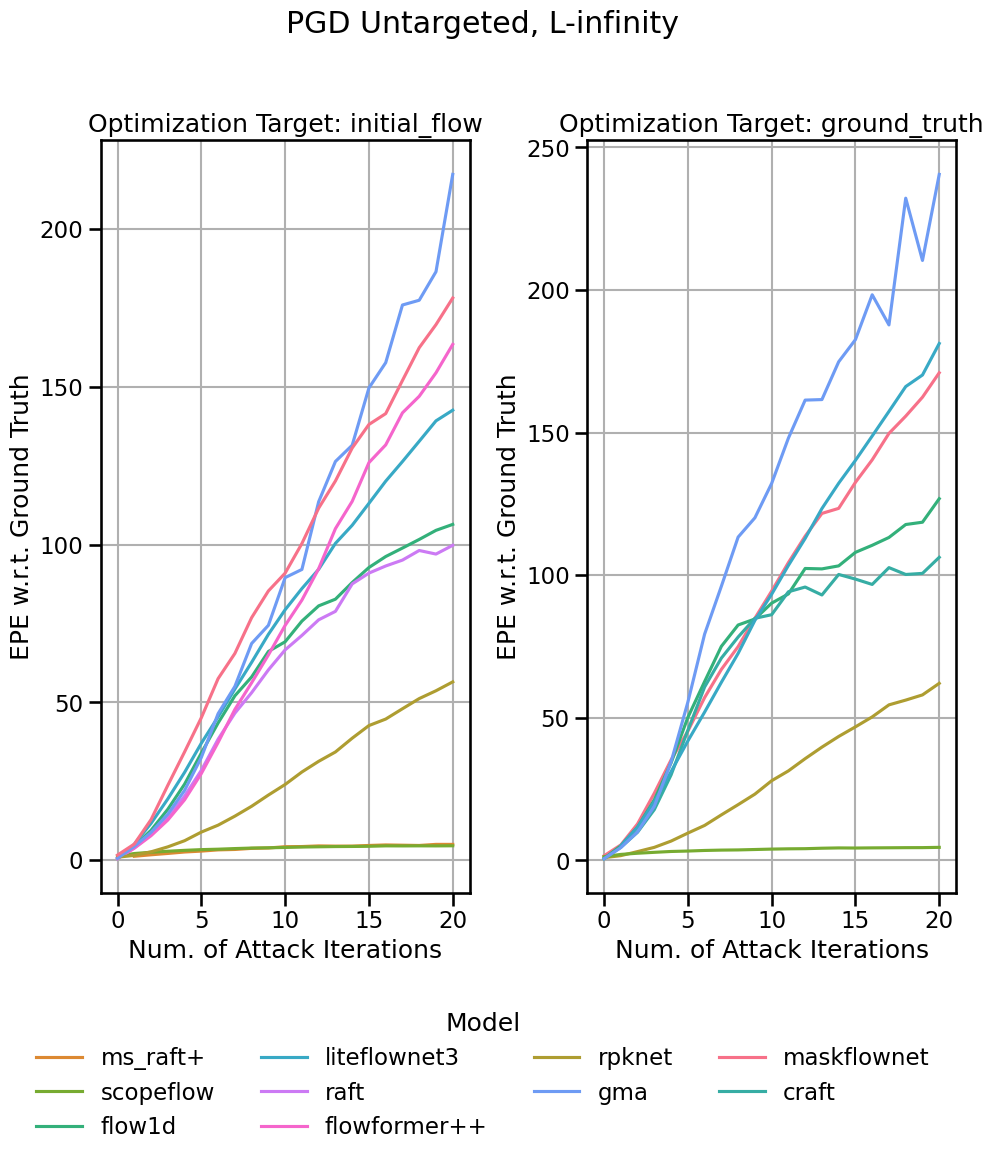

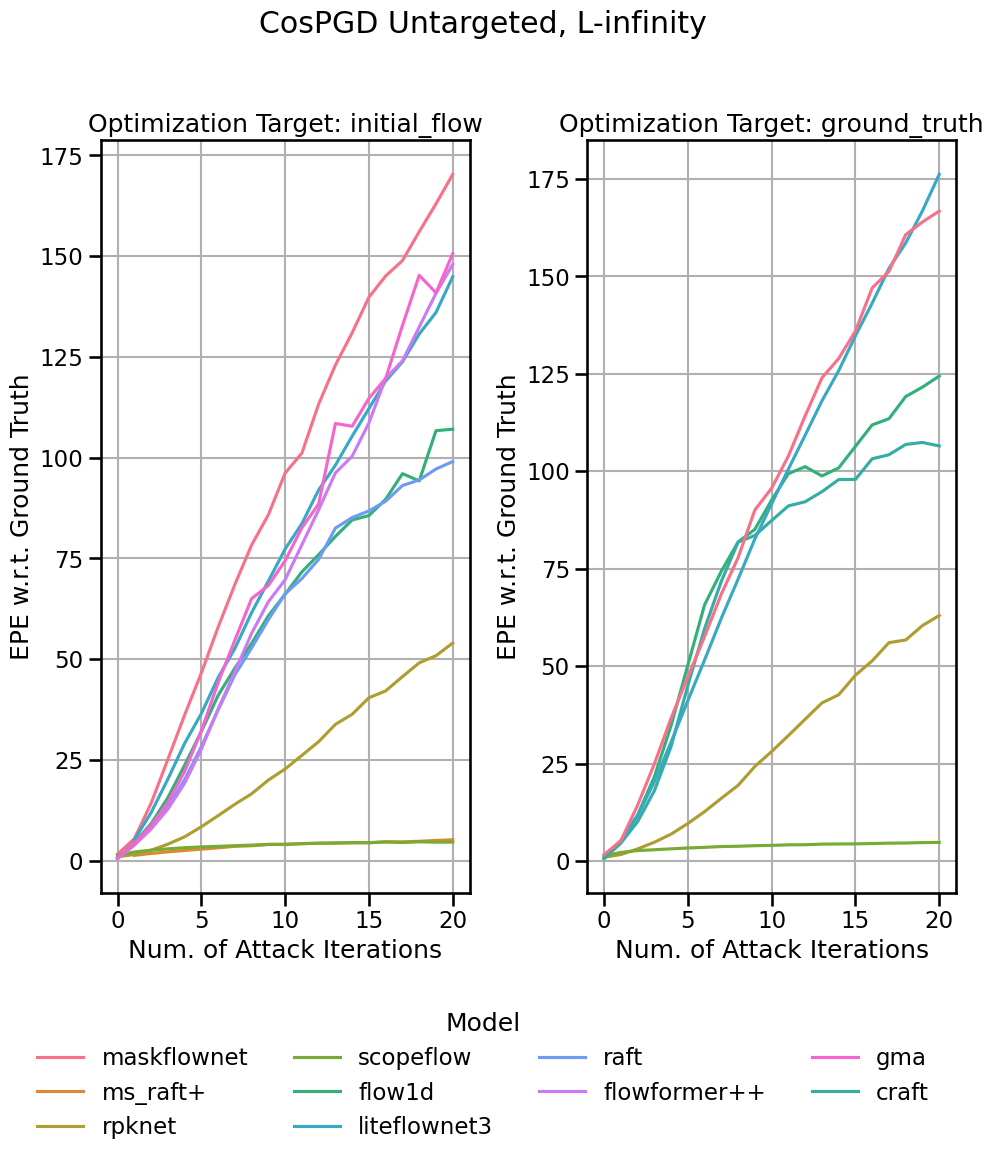

In [84]:
def plot(data, title, filename, optim_targets):
    num_optim_target = len(optim_targets)
    fig, axes = plt.subplots(1, num_optim_target, figsize=(5 * num_optim_target, 10))
    fig.suptitle(title)

    if num_optim_target == 1:
        axes = [axes]

    # Define a color palette explicitly
    unique_models = data['model'].unique()
    palette = sns.color_palette("husl", len(unique_models))
    model_palette = dict(zip(unique_models, palette))

    # Collect handles and labels for the legend
    handles, labels = [], []

    for ax, optim_target in zip(axes, optim_targets):
        # Filter the data for the current optimization target
        plot_data = data.query(f"optim == '{optim_target}' or epsilon == 0")
        # Create the line plot with consistent color mapping
        sns.lineplot(
            data=plot_data,
            x='iterations',
            y='epe',
            hue='model',
            palette=model_palette,  # Apply the predefined color palette
            ax=ax,
            errorbar=None
        )

        # Collect legend handles and labels from each plot
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

        ax.set_title(f'Optimization Target: {optim_target}')
        ax.set_xlabel('Num. of Attack Iterations')
        ax.set_ylabel('EPE w.r.t. Ground Truth')
        ax.grid(True)

    # Remove individual legends from each subplot
    for ax in axes:
        ax.legend_.remove()

    # Create a unique legend for the entire figure
    unique_handles_labels = dict(zip(labels, handles))
    fig.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=4, frameon=False, title='Model')

    # Adjust layout to fit title and legend
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'kitti-2015' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations', value_name='epe')
    melted_df['iterations'] = melted_df['iterations'].str.extract('(\d+)').astype(int)
    return melted_df


model_list = ["liteflownet3", "maskflownet", "flowformer++", "raft", "flow1d", "craft", "rpknet", "scopeflow", "gma", "ms_raft+"]

### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(iterations_df, model_list, query, wrt="gt")
plot(data_untargeted_inf, 'PGD Untargeted, L-infinity, KITTI-2015', 'graphs/PGD_kitti_init_flow.png', ["initial_flow", "ground_truth"])


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'kitti-2015' and (checkpoint == 'kitti' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(iterations_df, model_list, query, wrt="gt")
plot(data_untargeted_inf, 'CosPGD Untargeted, L-infinity, KITTI-2015', 'graphs/CosPGD_kitti_init_flow.png', ["initial_flow", "ground_truth"])


#### BIM/PGD/CosPGD init flow as optimization target -- Sintel-clean

Empty DataFrame
Columns: [model, epsilon, attack, optim, iterations, epe]
Index: []


/scratch/ipykernel_114914/401904908.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/scratch/ipykernel_114914/401904908.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


AttributeError: 'NoneType' object has no attribute 'remove'

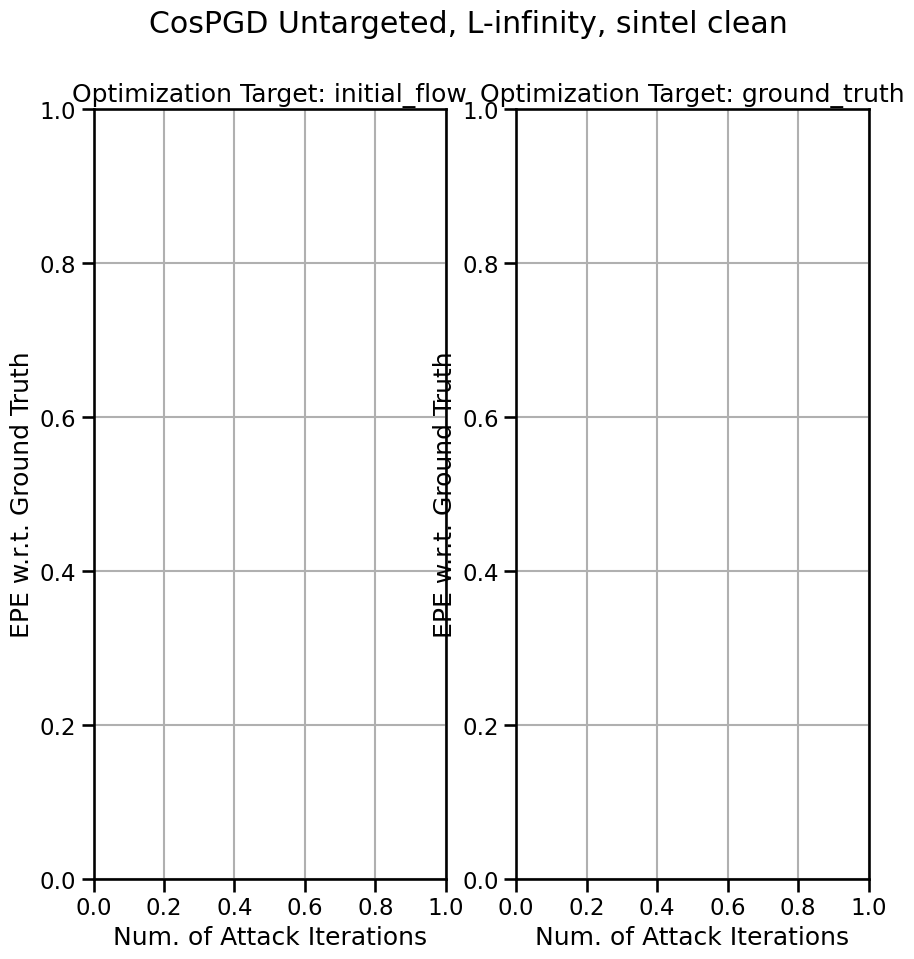

In [88]:
def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'sintel-clean' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations', value_name='epe')
    melted_df['iterations'] = melted_df['iterations'].str.extract('(\d+)').astype(int)
    return melted_df


model_list = ["liteflownet3", "maskflownet", "flowformer++", "raft", "flow1d", "craft", "rpknet", "scopeflow", "gma", "ms_raft+"]

### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(iterations_df, model_list, query, wrt="gt")
plot(data_untargeted_inf, 'PGD Untargeted, L-infinity, Sintel clean', 'graphs/PGD_sintel_clean_init_flow.png', ["initial_flow", "ground_truth"])


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(iterations_df, model_list, query, wrt="gt")
plot(data_untargeted_inf, 'CosPGD Untargeted, L-infinity, sintel clean', 'graphs/CosPGD_sintel_clean_init_flow.png', ["initial_flow", "ground_truth"])


#### BIM/PGD/CosPGD init flow as optimization target -- Sintel-final

In [ ]:
def transform_data(df, model_list, query, wrt):
    filtered_df = df.query(query + " or (attack == 'none' and dataset == 'sintel-clean' and model in @model_list)")
    # Reshape the data
    melted_df = filtered_df.melt(id_vars=['model', 'epsilon', 'attack', 'optim'], value_vars=[f'epe_{wrt}_i{i}' for i in range(0, 21)], var_name='iterations', value_name='epe')
    melted_df['iterations'] = melted_df['iterations'].str.extract('(\d+)').astype(int)
    return melted_df


model_list = ["liteflownet3", "maskflownet", "flowformer++", "raft", "flow1d", "craft", "rpknet", "scopeflow", "gma", "ms_raft+"]

### PGD ###

# Plot for untargeted attack
query = "attack == 'pgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(iterations_df, model_list, query, wrt="gt")
plot(data_untargeted_inf, 'PGD Untargeted, L-infinity, Sintel clean', 'graphs/PGD_sintel_clean_init_flow.png', ["initial_flow", "ground_truth"])


### CosPGD ###

# Plot for untargeted attack
query = "attack == 'cospgd' and norm == 'inf' and targeted == False and dataset == 'sintel-clean' and (checkpoint == 'sintel' or checkpoint == 'mixed') and epsilon == 0.0314 and model in @model_list"
data_untargeted_inf = transform_data(iterations_df, model_list, query, wrt="gt")
plot(data_untargeted_inf, 'CosPGD Untargeted, L-infinity, sintel clean', 'graphs/CosPGD_sintel_clean_init_flow.png', ["initial_flow", "ground_truth"])
